<a href="https://colab.research.google.com/github/benthiele/my-travel-plans/blob/master/PREPROCESS_SENTIMENT_CORRELATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

THIS NOTEBOOK CONTAINS
- TWO METHODS OF PRE-PROCESSING DATA (CLEANING AND Q&A INDEXING, NEUTRAL SENTENCE REMOVAL)
- THREE METHODS OF SENTIMENT ANALYSIS (VADER V1, VADER V2, RISK SCORES)
- TWO METHODS OF MEASURING CORRELATION/CAUSALITY BETWEEN %CHANGE IN SENTIMENT AT TIME T AND %CHANGE IN STOCK PRICE AT TIME T+1 (GRANGER CAUSALITY, SPEARMAN RANK CORRELATION)


In [ ]:
#!pip install vaderSentiment
from google.colab import drive
import pandas as pd
import numpy as np
import os
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import csv
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import spearmanr
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
drive.mount('/content/drive') # Connect to corpus in google drive

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DURING SENTIMENT ANALYSIS, WE WILL PLACE WEIGHTS ON THE Q&A SECTIONS OF THE EARNINGS CALL TRANSCRIPTS. WE USED THIS FUNCTION TO FIND AND REMOVE 5 TRANSCRIPTS THAT WERE MISSING THE Q&A SECTION FROM THE DATASET.

In [ ]:
def find_files_without_qa(directory):
    files_without_qa = []

    # Loop through all the files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as file:
                content = file.read()

            if "questions and answers" not in content.lower():
                files_without_qa.append(filename)

    return files_without_qa

# Directory containing the transcript files
input_directory = '/content/drive/Shareddrives/NLP/Earnings Calls/txt'

# Find files without "questions and answers"
files_without_qa = find_files_without_qa(input_directory)

# Print the list of filenames where "questions and answers" is not found
if files_without_qa:
    print("Files without 'questions and answers':")
    for filename in files_without_qa:
        print(filename)
else:
    print("All files contain 'questions and answers'.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/NLP Project/Earnings Calls/txt'

PRE-PROCESSING INCLUDES REMOVAL OF SPECIAL CHARACTERS, PUNCTUATION AND DIGITS AS WELL AS CONVERSION TO LOWERCASE, TOKENIZATION, STOP WORD REMOVAL, AND LEMMATIZATION. REPETITVE FOOTER TEXT IS ALSO REMOVED FROM ALL TRANSCRIPTS.

In [ ]:
# Besides cleaning, lemmatizing, and tokenizing, we also need to remove the
# first 8 lines from each transcript (irrelevant introductory info) and
# remove repetitve footer info
def preprocess_text(text):
    # Text Cleaning
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters, punctuation, and digits
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\bfactiva\b', '', text)  # Remove footer text
    text = re.sub(r'httpsglobalfactivacomproxyuchicagoeduhpprintsavewsaspxppstypearticleppprinthcpublication', '', text)  # Remove footer text
    text = re.sub(r'\bpm\b', '', text) # Remove footer text

    # Tokenization and removal of unnecessary white space
    tokens = [token for token in word_tokenize(text) if token.strip()]

    # Stop Word Removal (excluding negation words)
    negation_words = ['not', 'no', 'never', 'neither', 'nor', 'none', 'nobody', 'nothing', 'nowhere']
    stop_words = set(stopwords.words('english')) - set(negation_words)
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

In [ ]:
## ALTERNATE VERSION THAT KEEPS PUNCTUATION FOR SENTENCE ANALYSIS

def preprocess_keep_punctuation(text):
    # Text Cleaning
    text = re.sub(r'\d', '', text)  # Remove digits
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\bfactiva\b', '', text)  # Remove 'factiva'
    text = re.sub(r'httpsglobalfactivacomproxyuchicagoeduhpprintsavewsaspxppstypearticleppprinthcpublication', '', text)  # Remove specific footer text
    text = re.sub(r'\bpm\b', '', text)  # Remove 'pm'

    return text

APPLY THE CLEANING FUNCTION AND SAVE THE PROCESSED FILES

In [ ]:
def process_file(file_path, output_directory):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        lines = lines[8:-10]  # Remove the first 8 lines and the last 10 lines as they contain boiler plate introductory and concluding text

    processed_lines = []
    for line in lines:
        processed_line = preprocess_text(line)
        processed_lines.append(processed_line)

    # Remove empty lines from the processed text during join
    processed_text = '\n'.join(line for line in processed_lines if line.strip())

    output_file_path = os.path.join(output_directory, os.path.basename(file_path))
    with open(output_file_path, 'w') as file:
        file.write(processed_text)

# Directory containing the transcript files in your Google Drive
input_directory = '/content/drive/Shareddrives/NLP/Earnings Calls/txt'

# Directory to save the cleaned files in your Google Drive
output_directory = '/content/drive/Shareddrives/NLP/Earnings Calls/clean_txt'

# Loop through all the files in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith('.txt'):
        file_path = os.path.join(input_directory, filename)
        process_file(file_path, output_directory)
        print(f"Processed: {filename}")

Processed: Q1_2023_Pentair_PLC_Earnings_Call_-_Final_27_April_2023.txt
Processed: Q1_2023_Prologis_Inc_Earnings_Call_-_Final_18_April_2023.txt
Processed: Q1_2023_Public_Service_Enterprise_Group_Inc_Earnings_Call_-_Final_2_May_2023.txt
Processed: Q1_2023_PPG_Industries_Inc_Earnings_Call_-_Final_21_April_2023.txt
Processed: Q4_2022_PepsiCo_Inc_Earnings_Call_-_Final_9_February_2023.txt
Processed: Q4_2022_Principal_Financial_Group_Inc_Earnings_Call_-_Final_31_January_2023.txt
Processed: Q4_2022_Pentair_PLC_Earnings_Call_-_Final_31_January_2023.txt
Processed: Q4_2022_PayPal_Holdings_Inc_Earnings_Call_-_Final_9_February_2023.txt
Processed: Q4_2022_PNC_Financial_Services_Group_Inc_Earnings_Call_-_Final_18_January_2023.txt
Processed: Q4_2022_Prologis_Property_Mexico_SA_de_CV_Earnings_Call_-_Final_19_January_2023.txt
Processed: Q4_2022_Philip_Morris_International_Inc_Earnings_Call_-_Final_9_February_2023.txt
Processed: Q4_2022_Polaris_Inc_Earnings_Call_-_Final_31_January_2023.txt
Processed: Q4_

In [ ]:
## Separate Text Processing to Preserve Punctuation

def process_file_punctuation(file_path, output_directory):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        lines = lines[8:-10]  # Remove the first 8 lines and the last 10 lines as they contain boiler plate introductory and concluding text

    processed_lines = []
    for line in lines:
        processed_line = preprocess_keep_punctuation(line)
        processed_lines.append(processed_line)

    # Remove empty lines from the processed text during join
    processed_text = '\n'.join(line for line in processed_lines if line.strip())

    output_file_path = os.path.join(output_directory, os.path.basename(file_path))
    with open(output_file_path, 'w') as file:
        file.write(processed_text)

# Directory containing the transcript files in your Google Drive
input_directory = '/content/drive/Shareddrives/NLP/Earnings Calls/txt'

# Directory to save the cleaned files in your Google Drive
output_directory = '/content/drive/Shareddrives/NLP/Earnings Calls/clean_txt_with_punctuation'

# Loop through all the files in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith('.txt'):
        file_path = os.path.join(input_directory, filename)
        process_file_punctuation(file_path, output_directory)
        print(f"Processed: {filename}")

Processed: Q1_2023_Prologis_Property_Mexico_SA_de_CV_Earnings_Call_-_Final_19_April_2023.txt
Processed: Q4_2022_Stepan_Co_Earnings_Call_-_Final_16_February_2023.txt
Processed: Q1_2023_Pentair_PLC_Earnings_Call_-_Final_27_April_2023.txt
Processed: Q1_2023_Prologis_Inc_Earnings_Call_-_Final_18_April_2023.txt
Processed: Q1_2023_Public_Service_Enterprise_Group_Inc_Earnings_Call_-_Final_2_May_2023.txt
Processed: Q1_2023_PPG_Industries_Inc_Earnings_Call_-_Final_21_April_2023.txt
Processed: Q4_2022_PepsiCo_Inc_Earnings_Call_-_Final_9_February_2023.txt
Processed: Q4_2022_Principal_Financial_Group_Inc_Earnings_Call_-_Final_31_January_2023.txt
Processed: Q4_2022_Pentair_PLC_Earnings_Call_-_Final_31_January_2023.txt
Processed: Q4_2022_PayPal_Holdings_Inc_Earnings_Call_-_Final_9_February_2023.txt
Processed: Q4_2022_PNC_Financial_Services_Group_Inc_Earnings_Call_-_Final_18_January_2023.txt
Processed: Q4_2022_Prologis_Property_Mexico_SA_de_CV_Earnings_Call_-_Final_19_January_2023.txt
Processed: Q4_2

THE TEXT 'QUESTIONS AND ANSWERS' APPEARS AT THE BEGINNING OF EVERY Q&A SESSION IN THE TRANSCRIPTS. SEPARATE EACH TRANSCRIPT INTO A PRE-Q&A AND Q&A SECTION AND APPLY THE VADER ANALYZER TO EACH SECTION WHILE WEIGHTING THE Q&A SECTION MORE HEAVILY.

In [ ]:
def analyze_sentiment(lines):
    sid = SentimentIntensityAnalyzer()
    sentiments = []
    for line in lines:
        sentiment = sid.polarity_scores(line)
        sentiments.append(sentiment['compound'])

    average_sentiment = sum(sentiments) / len(sentiments) if sentiments else 0
    return average_sentiment

In [ ]:
def qa_weighting(input_directory):
    sentiment_data = []

    # Loop through all the files in the input directory
    for filename in os.listdir(input_directory):
        if filename.endswith('.txt'):
            file_path = os.path.join(input_directory, filename)
            with open(file_path, 'r') as file:
                content = file.read()

            # Find the index of "questions and answers" in the content
            qa_index = content.lower().find("question answer")

            # Split the content into pre-Q&A and post-Q&A sections
            pre_qa_content = content[:qa_index]
            post_qa_content = content[qa_index:]

            # Split the pre-Q&A and post-Q&A content into lines
            pre_qa_lines = pre_qa_content.split('\n')
            post_qa_lines = post_qa_content.split('\n')

            # Perform sentiment analysis on pre-Q&A section
            pre_qa_sentiment = analyze_sentiment(pre_qa_lines)

            # Perform sentiment analysis on post-Q&A section
            post_qa_sentiment = analyze_sentiment(post_qa_lines)

            # Assign weights to the sentiment scores
            pre_qa_weight = 1
            post_qa_weight = 2

            # Combine the weighted sentiment scores
            overall_sentiment = (pre_qa_weight * pre_qa_sentiment + post_qa_weight * post_qa_sentiment) / (pre_qa_weight + post_qa_weight)

            # Append the sentiment scores to the sentiment_data list
            sentiment_data.append([filename, pre_qa_sentiment, post_qa_sentiment, overall_sentiment])

    # Create a DataFrame from the sentiment_data list
    sentiment_df = pd.DataFrame(sentiment_data, columns=['Filename', 'Pre-Q&A Sentiment', 'Q&A Sentiment', 'Overall Sentiment'])

    return sentiment_df

# Directory containing the cleaned transcript files in your Google Drive
clean_txt_directory = '/content/drive/Shareddrives/NLP/Earnings Calls/clean_txt'

# Calculate the sentiment scores using the qa_weighting function
sentiment_df = qa_weighting(clean_txt_directory)

# Print the sentiment DataFrame
print(sentiment_df)

sentiment_df.to_csv('/content/drive/Shareddrives/NLP', index=False)

                                               Filename  Pre-Q&A Sentiment  \
0     Q1_2022_Equifax_Inc_Earnings_Call_-_Final_21_A...           0.308379   
1     Q1_2022_Edwards_Lifesciences_Corp_Earnings_Cal...           0.276339   
2     Q1_2022_Entergy_Corp_Earnings_Call_-_Final_27_...           0.266753   
3     Q4_2021_EOG_Resources_Inc_Earnings_Call_-_Fina...           0.344154   
4     Q1_2022_EQT_Corp_Earnings_Call_-_Final_28_Apri...           0.241392   
...                                                 ...                ...   
3672  Q2_2023_WEC_Energy_Group_Inc_Earnings_Call_-_F...           0.138820   
3673  Q2_2023_United_Parcel_Service_Inc_Earnings_Cal...           0.208750   
3674  Q2_2023_Welltower_Inc_Earnings_Call_-_Final_1_...           0.294044   
3675  Q2_2023_American_Vanguard_Corp_Earnings_Call_-...           0.160935   
3676  Q2_2023_Verisk_Analytics_Inc_Earnings_Call_-_F...           0.261906   

      Q&A Sentiment  Overall Sentiment  
0          0.256369   

IsADirectoryError: [Errno 21] Is a directory: '/content/drive/Shareddrives/NLP'

TESTING A THEORY. HERE I REMOVE ALL SENTENCES THAT HAVE NEUTRAL SENTIMENT AND KEEP ALL SENTENCES THAT HAVE POSITVE OR NEGATIVE SENTIMENT. THEN I WILL USE VADER AND SEE HOW THE SENTIMENT SCORES CHANGED WITH THIS APPROACH.

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
import re

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# REMOVE NEUTRAL SENTENCES FROM THE TEXT

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

def filter_neutral_sentences(file_path, output_directory):
    print(f"Processing file: {file_path}")

    # Read the input file
    with open(file_path, 'r') as file:
        text = file.read()

    # Split text into sentences
    sentences = sent_tokenize(text)
    print(f"Number of sentences: {len(sentences)}")

    filtered_sentences = []
    for sentence in sentences:
      sentiment = sid.polarity_scores(sentence)
      # Filter based on compound score threshold (consider absolute value)
      if abs(sentiment['compound']) > 0.5:  # Check for absolute value
        filtered_sentences.append(sentence)
        # print(f"Sentence: {sentence}")
        # print(f"Compound score: {sentiment['compound']}")

    print(f"Number of filtered sentences: {len(filtered_sentences)}")
    # Join filtered sentences back into a single string
    processed_text = ' '.join(filtered_sentences)

    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    output_file_path = os.path.join(output_directory, os.path.basename(file_path))
    with open(output_file_path, 'w') as file:
        file.write(processed_text)

# Directory containing the transcript files in your Google Drive
input_directory = '/content/drive/Shareddrives/NLP/Earnings Calls/clean_txt_with_punctuation'

# Directory to save the cleaned files in your Google Drive
output_directory = '/content/drive/Shareddrives/NLP/Earnings Calls/neutral_sentences_removed'

# Loop through all the files in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith('.txt'):
        file_path = os.path.join(input_directory, filename)
        filter_neutral_sentences(file_path, output_directory)
        print(f"Processed: {filename}")


Streaming output truncated to the last 5000 lines.
Processing file: /content/drive/Shareddrives/NLP/Earnings Calls/clean_txt_with_punctuation/Q2_2023_Darden_Restaurants_Inc_Earnings_Call_-_Final_16_December_2022.txt
Number of sentences: 733
Number of filtered sentences: 152
Processed: Q2_2023_Darden_Restaurants_Inc_Earnings_Call_-_Final_16_December_2022.txt
Processing file: /content/drive/Shareddrives/NLP/Earnings Calls/clean_txt_with_punctuation/Q3_2022_Corning_Inc_Earnings_Call_-_Final_25_October_2022.txt
Number of sentences: 422
Number of filtered sentences: 106
Processed: Q3_2022_Corning_Inc_Earnings_Call_-_Final_25_October_2022.txt
Processing file: /content/drive/Shareddrives/NLP/Earnings Calls/clean_txt_with_punctuation/Q3_2022_Coterra_Energy_Inc_Earnings_Call_-_Final_4_November_2022.txt
Number of sentences: 512
Number of filtered sentences: 124
Processed: Q3_2022_Coterra_Energy_Inc_Earnings_Call_-_Final_4_November_2022.txt
Processing file: /content/drive/Shareddrives/NLP/Earning

In [ ]:
def analyze_sentence_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    sentences = sent_tokenize(text)
    sentiments = []

    for sentence in sentences:
        sentiment = sid.polarity_scores(sentence)
        sentiments.append(sentiment['compound'])

    average_sentiment = sum(sentiments) / len(sentiments) if sentiments else 0

    return average_sentiment

In [ ]:
# Directory containing the transcript files
input_directory = '/content/drive/Shareddrives/NLP/Earnings Calls/neutral_sentences_removed'

# Output CSV file path
output_file = '/content/drive/Shareddrives/NLP/Earnings Calls/F.csv'

# Open the CSV file in write mode
with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(['Filename', 'Average Sentiment Score'])

    # Loop through all the files in the input directory
    for filename in os.listdir(input_directory):
        if filename.endswith('.txt'):
            file_path = os.path.join(input_directory, filename)

            # Read the content of the file
            with open(file_path, 'r') as file:
                content = file.read()

            # Calculate the average sentiment score
            average_sentiment = analyze_sentence_sentiment(content)

            # Write the filename and average sentiment score to the CSV file
            writer.writerow([filename, average_sentiment])

print("Sentiment scores saved to:", output_file)

Sentiment scores saved to: /content/drive/Shareddrives/NLP/Earnings Calls/sentiment_scores.csv


HAVING MERGED TOGETHER SOME OF OUR WORK IN EXCEL, WE UPLOAD A TABLE OF STOCK AND SENTIMENT DATA HERE AND USE IT TO CALCULATE THE GRANGER CAUSALITY SCORE

In [ ]:
# SORT ALL DATA BY TICKER AND EARNINGS CALL DATE

file_path = "/content/drive/Shareddrives/NLP/big_table.csv"
big_df = pd.read_csv(file_path)
big_df['Earnings Call Date'] = pd.to_datetime(big_df['Earnings Call Date'])
big_df['Stock Date'] = pd.to_datetime(big_df['Stock Date'])
# Columns to drop
columns_to_drop = [
    'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
    'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 9'
]
big_df = big_df.drop(columns=columns_to_drop)

big_df_sorted = big_df.sort_values(by=['Ticker','Earnings Call Date'])
big_df_sorted.head()

,Filename,Company Name,Ticker,Vader_1,Vader_2,Bert Sentiment,Earnings Call Date,Stock Date,Stock Price
3169,Q1_2022_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.315087,0.646172,NaN,2022-02-22,2022-02-22,130.490005
3174,Q2_2022_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.256385,0.614715,NaN,2022-05-24,2022-05-24,124.410004
3164,Q3_2022_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.278182,0.629945,NaN,2022-08-16,2022-08-16,132.770004
3128,Q4_2022_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.282346,0.648098,NaN,2022-11-21,2022-11-21,145.139999
3114,Q1_2023_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.289010,0.641047,NaN,2023-02-28,2023-02-28,141.970001


In [ ]:
# Function to calculate Granger causality
def calculate_granger_causality(sentiment_series, log_returns_series, lag=1):
    # Combine sentiment scores and log returns into a single DataFrame
    data = pd.DataFrame({'Sentiment': sentiment_series, 'Returns': log_returns_series})

    # Remove rows with NaN or infinite values
    data = data.replace([np.inf, -np.inf], np.nan).dropna()

    # Check if there are enough observations
    if len(data) > lag * 3 + 1:
        # Perform Granger causality test with the specified lag
        results = grangercausalitytests(data, maxlag=lag, verbose=False)

        # Extract the p-value for the specified lag
        p_value = results[lag][0]['ssr_ftest'][1]
    else:
        p_value = np.nan  # Not enough observations

    return p_value


In [ ]:
# EXTRACT PANDAS SERIES FOR CALCULATING GRANGER CAUSALITY SCORE
# Get unique tickers
unique_tickers = big_df_sorted['Ticker'].unique()

# Dictionary to store Granger causality scores for each Ticker
granger_scores = {}

for ticker in unique_tickers:
    # Filter data for the current ticker
    ticker_df = big_df_sorted[big_df_sorted['Ticker'] == ticker]

    # Extract Series for Vader scores and Stock Price
    vader_1_series = ticker_df['Vader_1']
    vader_2_series = ticker_df['Vader_2']
    stock_price_series = ticker_df['Stock Price']

    # Calculate log returns of Stock Price Series
    log_returns_series = np.log(stock_price_series.shift(-1) / stock_price_series)
    log_returns_series = log_returns_series.dropna()

    # Ensure the sentiment series match the length of log returns series
    vader_1_series = vader_1_series[:-1]  # Remove last element to match log returns length
    vader_2_series = vader_2_series[:-1]  # Remove last element to match log returns length

    # Calculate Granger causality scores for both Vader scores
    granger_score_vader_1 = calculate_granger_causality(vader_1_series, log_returns_series)
    granger_score_vader_2 = calculate_granger_causality(vader_2_series, log_returns_series)

    # Store the scores in the dictionary
    granger_scores[ticker] = {
        'Granger_Causality_Vader_1': granger_score_vader_1,
        'Granger_Causality_Vader_2': granger_score_vader_2
    }

# Convert the dictionary to a DataFrame
granger_df = pd.DataFrame.from_dict(granger_scores, orient='index').reset_index()
granger_df.columns = ['Ticker', 'Granger_Causality_Vader_1', 'Granger_Causality_Vader_2']

# Merge the Granger causality scores back into big_df_sorted
big_df_sorted = big_df_sorted.merge(granger_df, on='Ticker', how='left')

# Save the DataFrame to a CSV file
big_df_sorted.to_csv('/content/drive/Shareddrives/NLP/big_table_sorted.csv', index=False)

big_df_sorted.head()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print resul

,Filename,Company Name,Ticker,Vader_1,Vader_2,Bert Sentiment,Earnings Call Date,Stock Date,Stock Price,Granger_Causality_Vader_1,Granger_Causality_Vader_2
0,Q1_2022_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.315087,0.646172,NaN,2022-02-22,2022-02-22,130.490005,0.388838,0.679576
1,Q2_2022_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.256385,0.614715,NaN,2022-05-24,2022-05-24,124.410004,0.388838,0.679576
2,Q3_2022_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.278182,0.629945,NaN,2022-08-16,2022-08-16,132.770004,0.388838,0.679576
3,Q4_2022_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.282346,0.648098,NaN,2022-11-21,2022-11-21,145.139999,0.388838,0.679576
4,Q1_2023_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.289010,0.641047,NaN,2023-02-28,2023-02-28,141.970001,0.388838,0.679576


In [ ]:
# CALCULATE SPEARMAN RANK CORRELATIONS OF PERCENT CHANGE IN SENTIMENT AND STOCK PRICE
# The percent change in sentiment between time 0 and time 1 should correlate with the percent
# change in price between time 1 and time 2. Then we see if a leap in sentiment causes a leap in price.
def calculate_percent_change(series):
    return (series.shift(-1) - series) / series * 100

# EXTRACT PANDAS SERIES FOR CALCULATING SPEARMAN'S RANK CORRELATION
unique_tickers = big_df_sorted['Ticker'].unique()

# Dictionary to store Series and Spearman's rank correlation for each Ticker
ticker_data = {}

for ticker in unique_tickers:
    # Filter data for the current ticker
    ticker_df = big_df_sorted[big_df_sorted['Ticker'] == ticker]

    # Extract Series for Vader scores and Stock Price
    vader_1_series = ticker_df['Vader_1']
    vader_2_series = ticker_df['Vader_2']
    stock_price_series = ticker_df['Stock Price']

    # Calculate percent changes for Vader scores and Stock Price
    vader_1_pct_change = calculate_percent_change(vader_1_series)[:-1]  # Remove last NaN value
    vader_2_pct_change = calculate_percent_change(vader_2_series)[:-1]  # Remove last NaN value
    stock_price_pct_change = calculate_percent_change(stock_price_series)[:-1]  # Remove last NaN value

    # Remove the last element again from the sentiment series
    vader_1_pct_change = vader_1_pct_change[:-1]
    vader_2_pct_change = vader_2_pct_change[:-1]

    # Remove the first element from the stock price percent change series
    stock_price_pct_change = stock_price_pct_change[1:]

    # Calculate Spearman's rank correlation between Vader scores and shifted Stock Price percent changes
    correlation_vader_1, _ = spearmanr(vader_1_pct_change, stock_price_pct_change)
    correlation_vader_2, _ = spearmanr(vader_2_pct_change, stock_price_pct_change)

    # Create dictionary entry with Series and Spearman's rank correlation for this Ticker
    ticker_data[ticker] = {
        'Vader_1_Pct_Change': vader_1_pct_change,
        'Vader_2_Pct_Change': vader_2_pct_change,
        'Stock_Price_Pct_Change': stock_price_pct_change,
        'Spearman_Rank_Correlation_Vader_1': correlation_vader_1,
        'Spearman_Rank_Correlation_Vader_2': correlation_vader_2
    }

# Print data for the first Ticker
print(ticker_data)

{'A': {'Vader_1_Pct_Change': 0   -18.630408
1     8.501749
2     1.496845
3     2.360183
4   -20.035876
5   -12.156488
6    30.565485
Name: Vader_1, dtype: float64, 'Vader_2_Pct_Change': 0   -4.868291
1    2.477624
2    2.881589
3   -1.087875
4   -6.032739
5    0.057680
6    9.691507
Name: Vader_2, dtype: float64, 'Stock_Price_Pct_Change': 1     6.719717
2     9.316860
3    -2.184097
4    -9.389309
5    -2.324314
6    -9.287702
7    16.292331
Name: Stock Price, dtype: float64, 'Spearman_Rank_Correlation_Vader_1': 0.4642857142857144, 'Spearman_Rank_Correlation_Vader_2': 0.5357142857142858}, 'AAL': {'Vader_1_Pct_Change': 9    -13.596378
10    -9.532485
11    29.217571
12     9.936956
13    -4.175072
14    -1.149641
15     1.545384
16    -0.360227
Name: Vader_1, dtype: float64, 'Vader_2_Pct_Change': 9     -6.469810
10     0.895556
11    17.003023
12    -4.389985
13    -5.516784
14     7.484258
15    -0.133928
16    -7.450026
Name: Vader_2, dtype: float64, 'Stock_Price_Pct_Change': 10   -3

In [ ]:
# NOW ADD CORRELATION DATA BACK INTO THE BIG DATAFRAME FOR EASY EXPORT OF ALL RELEVANT DATA
# Create empty columns in big_df_sorted for Spearman Rank Correlation values
big_df_sorted['Spearman_Rank_Correlation_Vader_1'] = np.nan
big_df_sorted['Spearman_Rank_Correlation_Vader_2'] = np.nan

# Iterate over each ticker in ticker_data
for ticker, data in ticker_data.items():
    # Filter big_df_sorted for the current ticker
    ticker_df = big_df_sorted[big_df_sorted['Ticker'] == ticker]

    # Get the index of the filtered rows
    index = ticker_df.index

    # Insert the correlation values in the appropriate columns for all instances of the ticker
    big_df_sorted.loc[index, 'Spearman_Rank_Correlation_Vader_1'] = data['Spearman_Rank_Correlation_Vader_1']
    big_df_sorted.loc[index, 'Spearman_Rank_Correlation_Vader_2'] = data['Spearman_Rank_Correlation_Vader_2']

# Print the updated big_df_sorted
big_df_sorted.head(20)

# Specify the path to save the CSV file
path = '/content/drive/Shareddrives/NLP/big_table_sorted.csv'

# Save the DataFrame to the specified path
big_df_sorted.to_csv(path, index=False)

NOW WE CALCULATE A RISK SCORE FOR EACH TRANSCRIPT. THE RISK SCORE IS THE PROPORTION OF TRANSCRIPT WORDS THAT ARE IN THE RISK WORD SET.


In [ ]:
# Create a set of risk words made of all synonyms of risk, risky, uncertain, and uncertainty.
risk_synonyms = ['danger', 'exposure', 'hazard', 'liability', 'peril',
                 'possibility', 'prospect', 'uncertainty', 'delicate', 'dicey', 'hazardous',
                 'perilous', 'precarious', 'sensitive', 'speculative', 'treacherous', 'tricky',
                 'uncertain', 'unhealthy', 'unsafe', 'unsound', 'ambiguity', 'ambivalence',
                 'anxiety', 'concern', 'confusion', 'distrust', 'mistrust', 'skepticism',
                 'suspicion', 'trouble', 'uneasiness', 'unpredictability', 'worry', 'ambiguous',
                 'ambivalent', 'dubious', 'erratic', 'hazy', 'hesitant', 'insecure', 'precarious',
                 'questionable', 'risky', 'unclear', 'undecided', 'undetermined', 'unpredictable',
                 'unreliable', 'unresolved', 'unsettled', 'unsure', 'vague']

risk_synonyms = set(risk_synonyms)
print(risk_synonyms)

{'unresolved', 'anxiety', 'unclear', 'unsafe', 'uncertain', 'vague', 'tricky', 'unpredictable', 'uncertainty', 'precarious', 'treacherous', 'skepticism', 'worry', 'ambiguous', 'unpredictability', 'concern', 'sensitive', 'ambivalent', 'ambivalence', 'questionable', 'liability', 'unsound', 'hazardous', 'undecided', 'suspicion', 'dubious', 'hesitant', 'prospect', 'undetermined', 'unreliable', 'confusion', 'uneasiness', 'hazy', 'possibility', 'ambiguity', 'unhealthy', 'hazard', 'danger', 'peril', 'speculative', 'unsettled', 'distrust', 'erratic', 'mistrust', 'dicey', 'trouble', 'risky', 'unsure', 'exposure', 'delicate', 'insecure', 'perilous'}


In [ ]:
# RETURN THE RISK SCORES SEPARATED BY Q&A INDEXING
def calculate_risk_score(file_path, risk_words):
    # Read the cleaned text from the file
    with open(file_path, 'r') as file:
        content = file.read()

    # Find the index of "questions and answers" in the content
    qa_index = content.lower().find("question answer")

    # Split the content into pre-Q&A and Q&A sections
    pre_qa_content = content[:qa_index]
    qa_content = content[qa_index:]

    # Calculate risk score for pre-Q&A section
    pre_qa_words = pre_qa_content.split()
    pre_qa_risk_count = sum([1 for word in pre_qa_words if word in risk_words])
    pre_qa_total_words = len(pre_qa_words)
    pre_qa_risk_score = (pre_qa_risk_count / pre_qa_total_words) * 100 if pre_qa_total_words > 0 else 0

    # Calculate risk score for Q&A section
    qa_words = qa_content.split()
    qa_risk_count = sum([1 for word in qa_words if word in risk_words])
    qa_total_words = len(qa_words)
    qa_risk_score = (qa_risk_count / qa_total_words) * 100 if qa_total_words > 0 else 0

    # Assign weights to the risk scores
    pre_qa_weight = 1
    qa_weight = 2

    # Calculate the weighted average risk score
    overall_risk_score = (pre_qa_weight * pre_qa_risk_score + qa_weight * qa_risk_score) / (pre_qa_weight + qa_weight)

    # Extract the filename without the extension
    filename = os.path.basename(file_path)

    return filename, pre_qa_risk_score, qa_risk_score, overall_risk_score

# Directory containing the cleaned transcript files in your Google Drive
input_directory = '/content/drive/Shareddrives/NLP/Earnings Calls/clean_txt'

# Create an empty list to store the results
results = []

# Loop through all the files in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith('.txt'):
        file_path = os.path.join(input_directory, filename)
        filename, pre_qa_risk_score, qa_risk_score, overall_risk_score = calculate_risk_score(file_path, risk_synonyms)
        results.append((filename, pre_qa_risk_score, qa_risk_score, overall_risk_score))

# Create a dataframe from the results
risk_scores_df = pd.DataFrame(results, columns=['Filename', 'Pre-Q&A Risk Score', 'Q&A Risk Score', 'Overall Risk Score'])
risk_scores_df.to_csv('/content/drive/Shareddrives/NLP/Earnings Calls/risk_scores.csv', index=False)

# Merge risk_scores_df with big_df_sorted based on the filename
big_df_sorted = big_df_sorted.merge(risk_scores_df, left_on='Filename', right_on='Filename', how='left')
big_df_sorted.to_csv('/content/drive/Shareddrives/NLP/big_table_sorted.csv', index=False)

# Print the updated big_df_sorted
big_df_sorted.head(20)

,Filename,Company Name,Ticker,Vader_1,Vader_2,Bert Sentiment,Earnings Call Date,Stock Date,Stock Price,Granger_Causality_Vader_1,Granger_Causality_Vader_2,Spearman_Rank_Correlation_Vader_1,Spearman_Rank_Correlation_Vader_2,Pre-Q&A Risk Score_x,Q&A Risk Score_x,Overall Risk Score_x,Pre-Q&A Risk Score_y,Q&A Risk Score_y,Overall Risk Score_y
0,Q1_2022_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.315087,0.646172,NaN,2022-02-22,2022-02-22,130.490005,0.388838,0.679576,0.464286,0.535714,NaN,NaN,NaN,0.069156,0.115340,0.099946
1,Q2_2022_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.256385,0.614715,NaN,2022-05-24,2022-05-24,124.410004,0.388838,0.679576,0.464286,0.535714,NaN,NaN,NaN,0.124611,0.173139,0.156963
2,Q3_2022_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.278182,0.629945,NaN,2022-08-16,2022-08-16,132.770004,0.388838,0.679576,0.464286,0.535714,NaN,NaN,NaN,0.064267,0.080884,0.075345
3,Q4_2022_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.282346,0.648098,NaN,2022-11-21,2022-11-21,145.139999,0.388838,0.679576,0.464286,0.535714,NaN,NaN,NaN,0.315292,0.281114,0.292507
4,Q1_2023_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.289010,0.641047,NaN,2023-02-28,2023-02-28,141.970001,0.388838,0.679576,0.464286,0.535714,NaN,NaN,NaN,0.163132,0.116090,0.131771
5,Q2_2023_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.231104,0.602374,NaN,2023-05-23,2023-05-23,128.639999,0.388838,0.679576,0.464286,0.535714,NaN,NaN,NaN,0.201748,0.072657,0.115687
6,Q3_2023_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.203010,0.602722,NaN,2023-08-15,2023-08-15,125.650002,0.388838,0.679576,0.464286,0.535714,NaN,NaN,NaN,0.257898,0.092293,0.147495
7,Q4_2023_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.265061,0.661135,NaN,2023-11-20,2023-11-20,113.980003,0.388838,0.679576,0.464286,0.535714,NaN,NaN,NaN,0.267523,0.056132,0.126596
8,Q1_2024_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.269674,0.636049,NaN,2024-02-27,2024-02-27,132.550003,0.388838,0.679576,0.464286,0.535714,NaN,NaN,NaN,0.185071,0.025170,0.078470
9,Q4_2021_American_Airlines_Group_Inc_Earnings_C...,American Airlines,AAL,0.225894,0.595615,NaN,2022-01-20,2022-01-20,16.760000,0.676158,0.952411,0.285714,-0.071429,NaN,NaN,NaN,0.322581,0.112790,0.182721


In [ ]:
file_path = "/content/drive/Shareddrives/NLP/big_table_sorted.csv"
big_df_sorted = pd.read_csv(file_path)

# EXTRACT PANDAS SERIES FOR CALCULATING GRANGER CAUSALITY SCORE
# Get unique tickers
unique_tickers = big_df_sorted['Ticker'].unique()

# Dictionary to store Granger causality scores for each Ticker
granger_scores = {}

for ticker in unique_tickers:
    # Filter data for the current ticker
    ticker_df = big_df_sorted[big_df_sorted['Ticker'] == ticker]

    # Extract Series for Overall Risk Score and Stock Price
    risk_score_series = ticker_df['Overall Risk Score_y']
    stock_price_series = ticker_df['Stock Price']

    # Calculate log returns of Stock Price Series
    log_returns_series = np.log(stock_price_series.shift(-1) / stock_price_series)
    log_returns_series = log_returns_series.dropna()

    # Ensure the risk score series matches the length of log returns series
    risk_score_series = risk_score_series[:-1]  # Remove last element to match log returns length

    # Calculate Granger causality score for Overall Risk Score
    if len(risk_score_series) > 1 and len(log_returns_series) > 1:
        try:
            granger_score_risk = calculate_granger_causality(risk_score_series, log_returns_series)
            # Store the score in the dictionary, handle NaN values
            if isinstance(granger_score_risk, float) and isinstance(ticker, str):
                if np.isnan(granger_score_risk):
                    granger_score_risk = 0  # or None for null value
                granger_scores[ticker] = granger_score_risk
        except ValueError as e:
            print(f"Error processing ticker {ticker}: {e}")

# Convert the dictionary to a DataFrame
granger_df = pd.DataFrame.from_dict(granger_scores, orient='index').reset_index()
granger_df.columns = ['Ticker', 'Granger_Causality_Risk_Score']

# Merge the Granger causality scores back into big_df_sorted
big_df_sorted = big_df_sorted.merge(granger_df, on='Ticker', how='left')

# Save the DataFrame to a CSV file
big_df_sorted.to_csv('/content/drive/Shareddrives/NLP/big_table_sorted.csv', index=False)

big_df_sorted.head(20)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print resul

,Filename,Company Name,Ticker,Vader_1,Vader_2,Bert Sentiment,Earnings Call Date,Stock Date,Stock Price,Granger_Causality_Vader_1,Granger_Causality_Vader_2,Spearman_Rank_Correlation_Vader_1,Spearman_Rank_Correlation_Vader_2,Pre-Q&A Risk Score_y,Q&A Risk Score_y,Overall Risk Score_y,Granger_Causality_Risk_Score
0,Q1_2022_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.315087,0.646172,NaN,2/22/2022,2/22/2022,130.490005,0.388838,0.679576,0.464286,0.535714,0.06916,0.11534,0.09995,0.387101
1,Q2_2022_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.256385,0.614715,NaN,5/24/2022,5/24/2022,124.410004,0.388838,0.679576,0.464286,0.535714,0.12461,0.17314,0.15696,0.387101
2,Q3_2022_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.278182,0.629945,NaN,8/16/2022,8/16/2022,132.770004,0.388838,0.679576,0.464286,0.535714,0.06427,0.08088,0.07535,0.387101
3,Q4_2022_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.282346,0.648098,NaN,11/21/2022,11/21/2022,145.139999,0.388838,0.679576,0.464286,0.535714,0.31529,0.28111,0.29251,0.387101
4,Q1_2023_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.289010,0.641047,NaN,2/28/2023,2/28/2023,141.970001,0.388838,0.679576,0.464286,0.535714,0.16313,0.11609,0.13177,0.387101
5,Q2_2023_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.231104,0.602374,NaN,5/23/2023,5/23/2023,128.639999,0.388838,0.679576,0.464286,0.535714,0.20175,0.07266,0.11569,0.387101
6,Q3_2023_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.203010,0.602722,NaN,8/15/2023,8/15/2023,125.650002,0.388838,0.679576,0.464286,0.535714,0.25790,0.09229,0.14750,0.387101
7,Q4_2023_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.265061,0.661135,NaN,11/20/2023,11/20/2023,113.980003,0.388838,0.679576,0.464286,0.535714,0.26752,0.05613,0.12660,0.387101
8,Q1_2024_Agilent_Technologies_Inc_Earnings_Call...,"Agilent Technologies, Inc.",A,0.269674,0.636049,NaN,2/27/2024,2/27/2024,132.550003,0.388838,0.679576,0.464286,0.535714,0.18507,0.02517,0.07847,0.387101
9,Q4_2021_American_Airlines_Group_Inc_Earnings_C...,American Airlines,AAL,0.225894,0.595615,NaN,1/20/2022,1/20/2022,16.760000,0.676158,0.952411,0.285714,-0.071429,0.32258,0.11279,0.18272,0.657241


In [ ]:
# CALCULATE SPEARMAN RANK CORRELATIONS OF PERCENT CHANGE IN SENTIMENT AND STOCK PRICE
# The percent change in sentiment between time 0 and time 1 should correlate with the percent
# change in price between time 1 and time 2. Then we see if a leap in sentiment causes a leap in price.
def calculate_percent_change(series):
    return (series.shift(-1) - series) / series * 100

# EXTRACT PANDAS SERIES FOR CALCULATING SPEARMAN'S RANK CORRELATION
unique_tickers = big_df_sorted['Ticker'].unique()

# Dictionary to store Series and Spearman's rank correlation for each Ticker
ticker_data = {}

for ticker in unique_tickers:
    # Filter data for the current ticker
    ticker_df = big_df_sorted[big_df_sorted['Ticker'] == ticker]

    # Extract Series for Vader scores and Stock Price
    risk_score_series = ticker_df['Overall Risk Score_y']

    stock_price_series = ticker_df['Stock Price']

    # Calculate percent changes for Vader scores and Stock Price
    risk_score_pct_change = calculate_percent_change(risk_score_series)[:-1] # Remove last NaN value
    stock_price_pct_change = calculate_percent_change(stock_price_series)[:-1]  # Remove last NaN value

    # Remove the last element again from the sentiment series
    risk_score_pct_change = calculate_percent_change(risk_score_pct_change)[:-1]

    # Remove the first element from the stock price percent change series
    stock_price_pct_change = stock_price_pct_change[1:]

    # Calculate Spearman's rank correlation between Vader scores and shifted Stock Price percent changes
    correlation_risk_score, _ = spearmanr(risk_score_pct_change, stock_price_pct_change)

    # Create dictionary entry with Series and Spearman's rank correlation for this Ticker
    ticker_data[ticker] = {
        'Stock_Price_Pct_Change': stock_price_pct_change,
        'Spearman_Rank_Correlation_Risk_Score': correlation_risk_score
    }

# NOW ADD CORRELATION DATA BACK INTO THE BIG DATAFRAME FOR EASY EXPORT OF ALL RELEVANT DATA
# Create empty columns in big_df_sorted for Spearman Rank Correlation values
big_df_sorted['Spearman_Rank_Risk_Score'] = np.nan

# Iterate over each ticker in ticker_data
for ticker, data in ticker_data.items():
    # Filter big_df_sorted for the current ticker
    ticker_df = big_df_sorted[big_df_sorted['Ticker'] == ticker]

    # Get the index of the filtered rows
    index = ticker_df.index

    # Insert the correlation values in the appropriate columns for all instances of the ticker
    big_df_sorted.loc[index, 'Spearman_Rank_Correlation_Risk_Score'] = data['Spearman_Rank_Correlation_Risk_Score']

# Print the updated big_df_sorted
big_df_sorted.head(20)

# Specify the path to save the CSV file
path = '/content/drive/Shareddrives/NLP/big_table_sorted.csv'

# Save the DataFrame to the specified path
big_df_sorted.to_csv(path, index=False)

THIS IS THE FINAL SECTION OF THIS NOTEBOOK. CREATING HISTOGRAMS OF SPEARMAN RANK CORRELATIONS TO VISUALIZE THE RELIABILITY OF SENTIMENT SCORES AS LEADING PREDICTORS OF STOCK PRICE MOVEMENTS. ALL RESULTS UNFORTUNATELY ARE NORMALLY DISTRIBUTED AND CENTERED AT ZERO, INDICATING A TOTALLY RANDOM AND UNRELIABLE RELATIONSHIP BETWEEN SENTIMENT AND PRICE MOVEMENT.

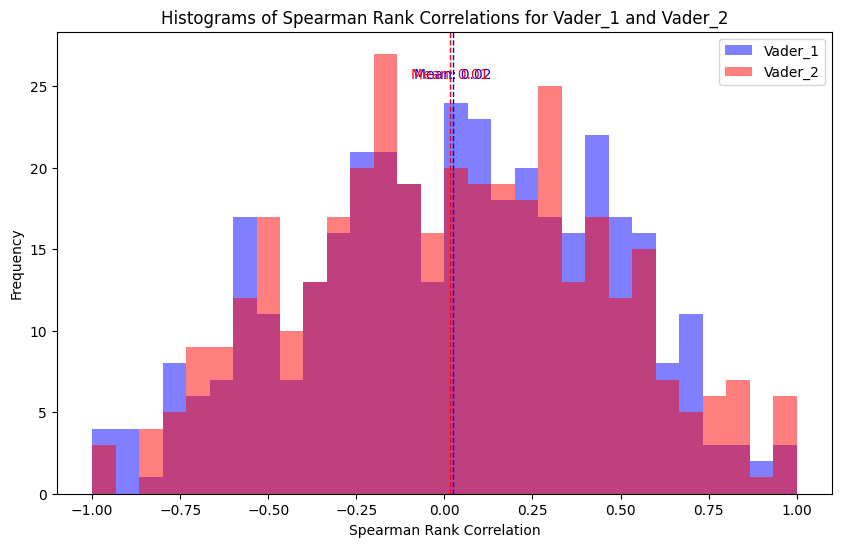

In [ ]:

import matplotlib.pyplot as plt

hist_directory = '/content/drive/Shareddrives/NLP/histogram_df.xlsx'
histogram_df = pd.read_excel(hist_directory)
# histogram_df.head(5)

# Calculate the means
mean_vader_1 = histogram_df['Spearman_Rank_Correlation_Vader_1'].mean()
mean_vader_2 = histogram_df['Spearman_Rank_Correlation_Vader_2'].mean()

# Plotting histograms
plt.figure(figsize=(10, 6))

# Plot first histogram
plt.hist(histogram_df['Spearman_Rank_Correlation_Vader_1'], bins=30, alpha=0.5, label='Vader_1', color='blue')

# Plot second histogram
plt.hist(histogram_df['Spearman_Rank_Correlation_Vader_2'], bins=30, alpha=0.5, label='Vader_2', color='red')

# Add vertical lines for the means
plt.axvline(mean_vader_1, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(mean_vader_2, color='red', linestyle='dashed', linewidth=1)

# Add text to indicate the mean values
plt.text(mean_vader_1, plt.ylim()[1] * 0.9, f'Mean: {mean_vader_1:.2f}', color='blue', ha='center')
plt.text(mean_vader_2, plt.ylim()[1] * 0.9, f'Mean: {mean_vader_2:.2f}', color='red', ha='center')

# Adding labels and title
plt.xlabel('Spearman Rank Correlation')
plt.ylabel('Frequency')
plt.title('Histograms of Spearman Rank Correlations for Vader_1 and Vader_2')

# Adding legend
plt.legend(loc='upper right')

# Display the plot
plt.show()

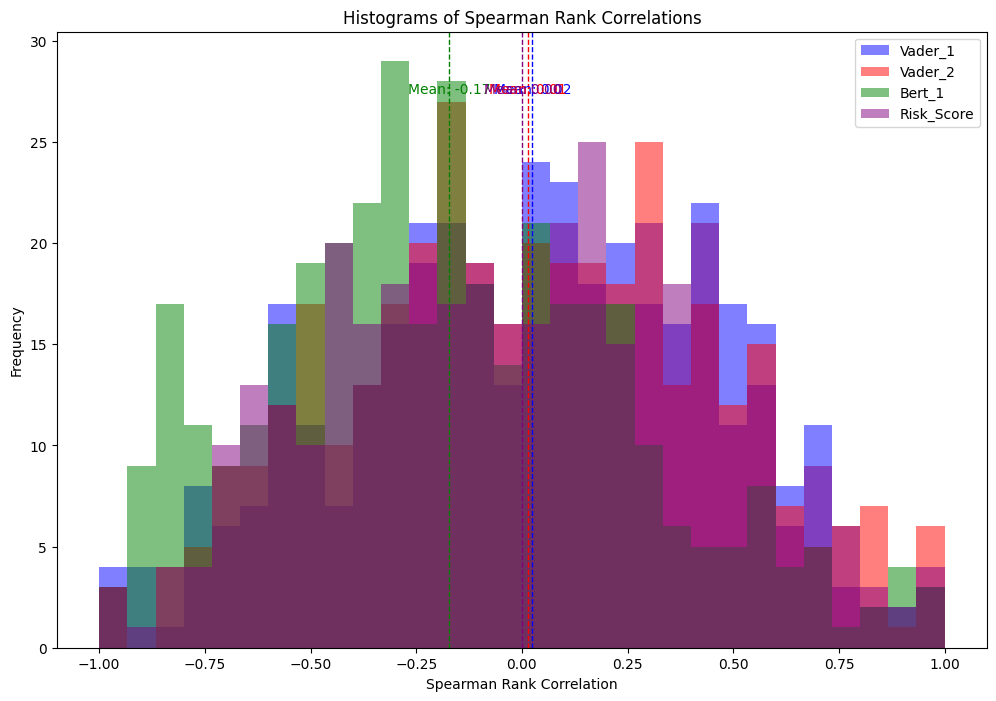

In [ ]:
# Calculate the means
mean_vader_1 = histogram_df['Spearman_Rank_Correlation_Vader_1'].mean()
mean_vader_2 = histogram_df['Spearman_Rank_Correlation_Vader_2'].mean()
mean_bert_1 = histogram_df['Spearman_Rank_Correlation_Bert_1'].mean()
mean_risk_score = histogram_df['Spearman_Rank_Correlation_Risk_Score'].mean()

# Plotting histograms
plt.figure(figsize=(12, 8))

# Plot histograms
plt.hist(histogram_df['Spearman_Rank_Correlation_Vader_1'], bins=30, alpha=0.5, label='Vader_1', color='blue')
plt.hist(histogram_df['Spearman_Rank_Correlation_Vader_2'], bins=30, alpha=0.5, label='Vader_2', color='red')
plt.hist(histogram_df['Spearman_Rank_Correlation_Bert_1'], bins=30, alpha=0.5, label='Bert_1', color='green')
plt.hist(histogram_df['Spearman_Rank_Correlation_Risk_Score'], bins=30, alpha=0.5, label='Risk_Score', color='purple')

# Add vertical lines for the means
plt.axvline(mean_vader_1, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(mean_vader_2, color='red', linestyle='dashed', linewidth=1)
plt.axvline(mean_bert_1, color='green', linestyle='dashed', linewidth=1)
plt.axvline(mean_risk_score, color='purple', linestyle='dashed', linewidth=1)

# Add text to indicate the mean values
plt.text(mean_vader_1, plt.ylim()[1] * 0.9, f'Mean: {mean_vader_1:.2f}', color='blue', ha='center')
plt.text(mean_vader_2, plt.ylim()[1] * 0.9, f'Mean: {mean_vader_2:.2f}', color='red', ha='center')
plt.text(mean_bert_1, plt.ylim()[1] * 0.9, f'Mean: {mean_bert_1:.2f}', color='green', ha='center')
plt.text(mean_risk_score, plt.ylim()[1] * 0.9, f'Mean: {mean_risk_score:.2f}', color='purple', ha='center')

# Adding labels and title
plt.xlabel('Spearman Rank Correlation')
plt.ylabel('Frequency')
plt.title('Histograms of Spearman Rank Correlations')

# Adding legend
plt.legend(loc='upper right')

# Display the plot
plt.show()

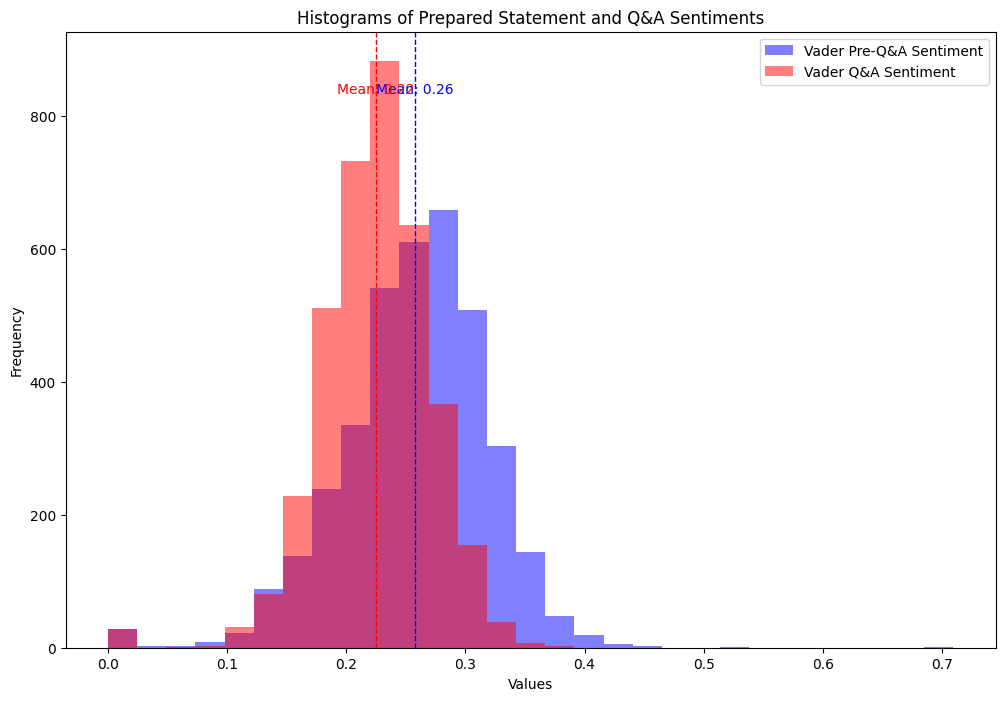

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load data
table_directory = '/content/drive/Shareddrives/NLP/big_table_sorted_final.xlsx'
big_df = pd.read_excel(table_directory)

# Calculate the means
mean_vader_pre = big_df['Vader Pre-Q&A Sentiment'].mean()
mean_vader_qa = big_df['Vader Q&A Sentiment'].mean()
# mean_pre_risk = big_df['Pre-Q&A Risk Score_y'].mean()
# mean_qa_risk = big_df['Q&A Risk Score_y'].mean()

# Plotting histograms
plt.figure(figsize=(12, 8))

# Define bins
bins = np.linspace(min(big_df['Vader Pre-Q&A Sentiment'].min(), big_df['Vader Q&A Sentiment'].min()),
                   max(big_df['Vader Pre-Q&A Sentiment'].max(), big_df['Vader Q&A Sentiment'].max()), 30)

# Plot histograms
plt.hist(big_df['Vader Pre-Q&A Sentiment'], bins=bins, alpha=0.5, label='Vader Pre-Q&A Sentiment', color='blue')
plt.hist(big_df['Vader Q&A Sentiment'], bins=bins, alpha=0.5, label='Vader Q&A Sentiment', color='red')
# plt.hist(big_df['Pre-Q&A Risk Score_y'], bins=30, alpha=0.5, label='Pre-Q&A Risk Score_y', color='green')
# plt.hist(big_df['Q&A Risk Score_y'], bins=30, alpha=0.5, label='Q&A Risk Score_y', color='purple')

# Add vertical lines for the means
plt.axvline(mean_vader_pre, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(mean_vader_qa, color='red', linestyle='dashed', linewidth=1)
# plt.axvline(mean_pre_risk, color='green', linestyle='dashed', linewidth=1)
# plt.axvline(mean_qa_risk, color='purple', linestyle='dashed', linewidth=1)

# Add text to indicate the mean values
plt.text(mean_vader_pre, plt.ylim()[1] * 0.9, f'Mean: {mean_vader_pre:.2f}', color='blue', ha='center')
plt.text(mean_vader_qa, plt.ylim()[1] * 0.9, f'Mean: {mean_vader_qa:.2f}', color='red', ha='center')
# plt.text(mean_pre_risk, plt.ylim()[1] * 0.9, f'Mean: {mean_pre_risk:.2f}', color='green', ha='center')
# plt.text(mean_qa_risk, plt.ylim()[1] * 0.9, f'Mean: {mean_qa_risk:.2f}', color='purple', ha='center')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of Prepared Statement and Q&A Sentiments')

# Adding legend
plt.legend(loc='upper right')

# Display the plot
plt.show()


In [ ]:
# # CALCULATE SPEARMAN RANK CORRELATIONS OF PERCENT CHANGE IN SENTIMENT AND STOCK PRICE
# # The percent change in sentiment between time 0 and time 1 should correlate with the percent
# # change in price between time 1 and time 2. Then we see if a leap in sentiment causes a leap in price.
# def calculate_percent_change(series):
#     return (series.shift(-1) - series) / series * 100


# sp_directory = '/content/drive/Shareddrives/NLP/sp500.xlsx'
# sp_df = pd.read_excel(sp_directory)
# # sp_df.head(5)

# # # EXTRACT PANDAS SERIES FOR CALCULATING SPEARMAN'S RANK CORRELATION
# # unique_tickers = sp_df['Ticker'].unique()

# # Dictionary to store Series and Spearman's rank correlation for each Ticker
# ticker_data = {}

# # for ticker in unique_tickers:
# # # Filter data for the current ticker
# # ticker_df = sp_df[sp_df['Ticker'] == ticker]

# # Extract Series for Vader scores and Stock Price
# risk_score_series = sp_df['Bert Sentiment']
# # print(risk_score_series)
# stock_price_series = sp_df['Stock Price']

# # Calculate percent changes for Vader scores and Stock Price
# risk_score_pct_change = calculate_percent_change(risk_score_series)[:-1] # Remove last NaN value
# stock_price_pct_change = calculate_percent_change(stock_price_series)[:-1]  # Remove last NaN value

# # Remove the last element again from the sentiment series
# risk_score_pct_change = calculate_percent_change(risk_score_pct_change)[:-1]

# # Remove the first element from the stock price percent change series
# stock_price_pct_change = stock_price_pct_change[1:]

# # Calculate Spearman's rank correlation between Vader scores and shifted Stock Price percent changes
# correlation_risk_score, _ = spearmanr(risk_score_pct_change, stock_price_pct_change)

# # Create dictionary entry with Series and Spearman's rank correlation for this Ticker
# ticker_data[ticker] = {
#     'Stock_Price_Pct_Change': stock_price_pct_change,
#     'Spearman_Rank_Correlation_Bert': correlation_risk_score
# }

# print(ticker_data)
# # NOW ADD CORRELATION DATA BACK INTO THE BIG DATAFRAME FOR EASY EXPORT OF ALL RELEVANT DATA
# # Create empty columns in big_df_sorted for Spearman Rank Correlation values
# sp_df['Spearman_Rank_Correlation_Bert'] = np.nan

# # Iterate over each ticker in ticker_data
# for ticker, data in ticker_data.items():
#     # Filter big_df_sorted for the current ticker
#     ticker_df = sp_df[sp_df['Ticker'] == ticker]

#     # Get the index of the filtered rows
#     index = ticker_df.index

#     # Insert the correlation values in the appropriate columns for all instances of the ticker
#     sp_df.loc[index, 'Spearman_Rank_Correlation_Bert'] = data['Spearman_Rank_Correlation_Bert']

# # Print the updated big_df_sorted
# sp_df.head()

# # Specify the path to save the CSV file
# path = '/content/drive/Shareddrives/NLP/sp_spearman.csv'

# # Save the DataFrame to the specified path
# sp_df.to_csv(path, index=False)

In [ ]:
# # EXTRACT PANDAS SERIES FOR CALCULATING GRANGER CAUSALITY SCORE
# # Get unique tickers
# # unique_tickers = big_df_sorted['Ticker'].unique()

# # Dictionary to store Granger causality scores for each Ticker
# granger_scores = {}

# for ticker in unique_tickers:
#     # # Filter data for the current ticker
#     # ticker_df = big_df_sorted[big_df_sorted['Ticker'] == ticker]

#     # Extract Series for Vader scores and Stock Price
#     bert_1_series = sp_df['Bert Sentiment']
#     stock_price_series = ticker_df['Stock Price']

#     # Calculate log returns of Stock Price Series
#     log_returns_series = np.log(stock_price_series.shift(-1) / stock_price_series)
#     log_returns_series = log_returns_series.dropna()

#     # Ensure the sentiment series match the length of log returns series
#     bert_1_series = bert_1_series[:-1]  # Remove last element to match log returns length

#     # Calculate Granger causality scores for both Vader scores
#     granger_score_bert_1_series = calculate_granger_causality(bert_1_series, log_returns_series)
#     print(granger_score_bert_1_series)
#     # Store the scores in the dictionary
#     granger_scores[ticker] = {
#         'Granger_Causality_Bert_1': granger_score_bert_1_series
#     }

# print(granger_scores)

In [ ]:
#USED THIS TO INSPECT THE RISK SCORE STUFF IN MORE DETAIL. DON'T NEED IT ANYMORE. BUT DON'T WANT TO DELETE IT YET.
# import re
# from collections import Counter

# def unique_words_in_file(file_path):
#     with open(file_path, 'r') as file:
#         text = file.read()

#     # Remove punctuation and make lowercase
#     text = re.sub(r'[^\w\s]', '', text).lower()

#     # Split the text into words
#     words = text.split()

#     # Get the set of unique words
#     unique_words = set(words)
#     # Create a Counter to count word occurrences
#     word_counts = Counter(words)

#     return unique_words, word_counts

# file_path = '/content/drive/Shareddrives/NLP/Earnings Calls/clean_txt/Q1_2022_Las_Vegas_Sands_Corp_Earnings_Call_-_Final_27_April_2022.txt'  # Adjust the file extension if necessary
# unique_words, word_counts = unique_words_in_file(file_path)

# # Define the set of risk synonyms
risk_synonyms = ['danger', 'exposure', 'hazard', 'liability', 'peril',
                 'possibility', 'prospect', 'uncertainty', 'delicate',
                 'dicey', 'hazardous', 'perilous', 'precarious', 'sensitive',
                 'speculative', 'treacherous', 'tricky','uncertain',
                 'unhealthy', 'unsafe', 'unsound', 'ambiguity',
                 'ambivalence','anxiety', 'concern', 'confusion',
                 'distrust', 'mistrust', 'skepticism','suspicion',
                 'trouble', 'uneasiness', 'unpredictability',
                 'worry', 'ambiguous', 'ambivalent', 'dubious',
                 'erratic', 'hazy', 'hesitant', 'insecure', 'precarious',
                 'questionable', 'risky', 'unclear', 'undecided',
                 'undetermined', 'unpredictable', 'unreliable',
                 'unresolved', 'unsettled', 'unsure', 'vague']

# # Find the unique words that are also in the risk_synonyms set
# common_words = unique_words.intersection(risk_synonyms)

# # Print the counts for each common word
# common_word_counts = {word: word_counts[word] for word in common_words}

# print(f'Unique words in the file: {unique_words}')
# print(f'Total unique words: {len(unique_words)}')
# print(f'Number of unique words that are risk synonyms: {len(common_words)}')
# print(f'Counts of common words: {common_word_counts}')


Unique words in the file: {'point', 'bofa', 'china', 'book', 'anyway', 'nongaap', 'recorded', 'cool', 'omission', 'reopen', 'reinvest', 'reopening', 'substance', 'new', 'director', 'appropriate', 'colleague', 'amenity', 'pretty', 'pandemic', 'co', 'george', 'available', 'price', 'robin', 'joining', 'not', 'tendering', 'curious', 'hold', 'hear', 'quarantine', 'type', 'sign', 'document', 'simplistically', 'attainable', 'st', 'entity', 'february', 'postcovid', 'mb', 'unidentified', 'global', 'larger', 'youre', 'weve', 'replaced', 'choi', 'segment', 'huge', 'equation', 'reporting', 'great', 'universal', 'ruled', 'briggs', 'driver', 'history', 'fund', 'suite', 'driven', 'shouldnt', 'dr', 'balance', 'proceeds', 'buying', 'instruction', 'steve', 'virtue', 'fully', 'business', 'discus', 'found', 'side', 'faith', 'md', 'innovation', 'sar', 'sale', 'window', 'considerable', 'jointly', 'putting', 'vice', 'continue', 'grant', 'clearly', 'excess', 'inaccuracy', 'effect', 'deposit', 'benjamin', 'tak